In [1]:
%load_ext autoreload
%autoreload 2

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import PowerNorm


from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable

import warnings; warnings.simplefilter('ignore')
import sys
sys.path.insert(0, '/Users/jsmonzon/Research/SatGen/mcmc/src/')
import jsm_halopull
import jsm_SHMR
import jsm_mcmc
import jsm_stats
import jsm_models


:::{admonition} TIP
:class: hint
Enter Text here
:::

In [3]:
plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['axes.labelsize'] = 15
plt.rc('legend',fontsize=15) # using a size in points


In [4]:
halo_masses = np.linspace(8,12,100) # just for the model

In [5]:
mass_example = np.load("../../../data/MW-analog/meta_data_psi4/models.npz")["mass"]
red_example = np.load("../../../data/MW-analog/meta_data_psi4/models.npz")["redshift"]

mass_example = np.vstack(mass_example)
red_example = np.vstack(red_example)

In [6]:
N = 200

binH = np.linspace(8,12,N)
binS = np.linspace(2,10,N)

In [7]:
# def plot_SHMR_dist(theta, theta_det, model_label, save_file=None):

#     stellar_example = jsm_SHMR.general(theta, mass_example, red_example)

#     flat_H = mass_example.flatten()
#     flat_S = stellar_example.flatten()
#     nanmask = ~np.isnan(flat_H)

#     plt.figure(figsize=(8, 6))
#     plt.title(model_label, fontsize=15)
#     plt.hist2d(flat_H[nanmask], flat_S[nanmask], bins=(binH, binS), norm=PowerNorm(gamma=0.15), cmap="Blues")
#     plt.plot(halo_masses, jsm_SHMR.general(theta_det, halo_masses,0), color="navy", label="Deterministic Relation", lw=2)
#     plt.plot(halo_masses, jsm_SHMR.lgMs_B13(halo_masses, 0), color="red", ls="--", label="Behroozi 2013", lw=2)
#     plt.plot(halo_masses, jsm_SHMR.lgMs_RP17(halo_masses, 0), color="orange", ls="--", label="Rodriguez-Puebla 2017", lw=2)
#     plt.ylabel("log m$_{*}$ [M$_\odot$]", fontsize=15)
#     plt.xlabel("log m$_{\mathrm{acc}}$ [M$_\odot$]", fontsize=15)
#     plt.yticks(fontsize=12)
#     plt.xticks(fontsize=12)
#     plt.grid(False)

#     plt.legend(fontsize=15)

#     if save_file !=None:
#         plt.savefig("../../SatGen/mcmc/figures/paper/"+save_file)
#     plt.show()

In [8]:
# def plot_contour(theta, theta_det, model_label, redshift=False, legend=False, save_file=None):

#     halo_masses = np.linspace(8,12,100) # just for the plotting

#     stellar_example = jsm_SHMR.general(theta, mass_example, red_example)

#     flat_H = mass_example.flatten()
#     flat_S = stellar_example.flatten()
#     nanmask = ~np.isnan(flat_H)

#     hist, xedges, yedges = np.histogram2d(flat_H[nanmask], flat_S[nanmask], bins=(binH, binS))

#     fig, ax = plt.subplots(figsize=(8, 6))
#     ax.set_title(model_label, fontsize=15)

#     levels = np.linspace(0, hist.max(), 10)  # Adjust the number of levels as needed
#     contour = ax.contour(xedges[:-1], yedges[:-1], hist.T, [0.5], colors="cornflowerblue", label="scatter")
#     ax.plot(halo_masses, jsm_SHMR.general(theta_det, halo_masses,0), color="navy", label="Deterministic Relation", lw=2)
#     plt.plot(halo_masses, jsm_SHMR.lgMs_B13(halo_masses, 0), color="red", ls="--", label="Behroozi 2013", lw=2)
#     plt.plot(halo_masses, jsm_SHMR.lgMs_RP17(halo_masses, 0), color="orange", ls="--", label="Rodriguez-Puebla 2017", lw=2)

#     if redshift==True:
#         z_array = np.arange(10)

#         cmap = plt.get_cmap('plasma')  # You can choose a different colormap
#         colors = cmap(np.linspace(0, 1, z_array.shape[0]))
#         custom_cmap = ListedColormap(colors)

#         for i in z_array:   
#             ax.plot(halo_masses, jsm_SHMR.general(theta_det, halo_masses, i), lw=2, color=colors[i])
        
#         norm = plt.Normalize(0, 9)
#         sm = ScalarMappable(cmap=custom_cmap, norm=norm)
#         sm.set_array([])

#         cax = ax.inset_axes([0.55, 0.15,0.4, 0.04])
#         colorbar = fig.colorbar(sm, cax=cax, ticks=z_array, orientation='horizontal')
#         colorbar.ax.tick_params(axis='both', which='major', labelsize=12)
#         colorbar.set_label('z$_{\mathrm{acc}}$', fontsize=15)

#     plt.ylabel("log m$_{*}$ [M$_\odot$]", fontsize=15)
#     plt.xlabel("log m$_{\mathrm{acc}}$ [M$_\odot$]", fontsize=15)
#     plt.xlim(8, 11.7)
#     plt.ylim(2.3, 10.5)
#     if legend==True:
#         plt.legend(fontsize=15)

#     if save_file!=None:
#         plt.savefig(save_file)

#     plt.show()

In [71]:
def SHMR_PLOT(theta, model_label=None, mock=None, redshift=False, hist2d=True, contour=True, comparison=False, legend=False, save_file=None):

    stellar_example = jsm_SHMR.general(theta, mass_example, red_example)
    theta_det = theta[:2] + [0, 0] + theta[4:]

    flat_H = mass_example.flatten()
    flat_S = stellar_example.flatten()
    nanmask = ~np.isnan(flat_H)

    hist, xedges, yedges = np.histogram2d(flat_H[nanmask], flat_S[nanmask], bins=(binH, binS))

    fig, ax = plt.subplots(figsize=(8, 6))

    for i, Ms in enumerate(stellar_example):
        plt.plot(mass_example[i], Ms, alpha=0.01, color="grey")

    if model_label!=None:
        ax.set_title(model_label, fontsize=15)

    if hist2d==True:
        plt.hist2d(flat_H[nanmask], flat_S[nanmask], bins=(binH, binS), cmap="Blues")

    if contour==True:
        levels = np.linspace(0, hist.max(), 10)  # Adjust the number of levels as needed
        contour = ax.contour(xedges[:-1], yedges[:-1], hist.T, [0.5], colors="cornflowerblue", label="scatter")
        
    if comparison==True:
        ax.plot(halo_masses, jsm_SHMR.lgMs_B13(halo_masses, 0), color="red", ls="--", label="Behroozi 2013", lw=2)
        ax.plot(halo_masses, jsm_SHMR.lgMs_RP17(halo_masses, 0), color="orange", ls="--", label="Rodriguez-Puebla 2017", lw=2)

    ax.plot(halo_masses, jsm_SHMR.general(theta_det, halo_masses,0), color="navy", label="Deterministic Relation", lw=2)

    if redshift==True:
        z_array = np.arange(10)

        cmap = plt.get_cmap('plasma')  # You can choose a different colormap
        colors = cmap(np.linspace(0, 1, z_array.shape[0]))
        custom_cmap = ListedColormap(colors)

        for i in z_array:   
            ax.plot(halo_masses, jsm_SHMR.general(theta_det, halo_masses, i), lw=2, color=colors[i])
        
        norm = plt.Normalize(0, 9)
        sm = ScalarMappable(cmap=custom_cmap, norm=norm)
        sm.set_array([])

        cax = ax.inset_axes([0.55, 0.15,0.4, 0.04])
        colorbar = fig.colorbar(sm, cax=cax, ticks=z_array, orientation='horizontal')
        colorbar.ax.tick_params(axis='both', which='major', labelsize=12)
        colorbar.set_label('z$_{\mathrm{acc}}$', fontsize=15)

    if mock==True:
        mock_index = np.random.randint(0,10000,100)
        mock_lgMh, mock_lgMs = mass_example[mock_index, :], stellar_example[mock_index, :]
        mass_cut = mock_lgMs > 6.5
        ax.scatter(mock_lgMh[mass_cut], mock_lgMs[mass_cut], marker="*", s=9, color="black", label="Mock Survey")

    ax.set_ylabel("log m$_{*}$ [M$_\odot$]", fontsize=15)
    ax.set_xlabel("log m$_{\mathrm{acc}}$ [M$_\odot$]", fontsize=15)
    ax.set_xlim(8, 11.7)
    ax.set_ylim(4, 10)
    if legend==True:
        ax.legend(fontsize=15)

    if save_file!=None:
        ax.savefig(save_file)

    plt.show()

In [144]:
def new_SHMR(theta, model_color, model_label=None, mock=True, redshift=False, comparison=False, legend=False, save_file=None):

    stellar_example = jsm_SHMR.general(theta, mass_example, red_example)
    theta_det = theta[:2] + [0, 0] + theta[4:]

    fig, ax = plt.subplots(figsize=(8, 6))

    if model_label!=None:
        ax.set_title(model_label, fontsize=15)

    if comparison==True:
        ax.plot(halo_masses, jsm_SHMR.lgMs_B13(halo_masses, 0), color="red", ls="--", label="Behroozi 2013", lw=2)
        ax.plot(halo_masses, jsm_SHMR.lgMs_RP17(halo_masses, 0), color="orange", ls="--", label="Rodriguez-Puebla 2017", lw=2)

    det = jsm_SHMR.general(theta_det, halo_masses, 0)
    ax.plot(halo_masses, det, color=model_color, label="Deterministic Relation", lw=2)

    sigma = theta[2] + theta[3]*(halo_masses-12)
    
    ax.fill_between(halo_masses, det - sigma, det + sigma, color=model_color, alpha=0.3, ) 
    ax.fill_between(halo_masses, det - 2*sigma, det + 2*sigma, color=model_color, alpha=0.2, ) 
    ax.fill_between(halo_masses, det - 3*sigma, det + 3*sigma, color=model_color, alpha=0.1, ) 

    if redshift==True:
        z_array = np.arange(10)

        cmap = plt.get_cmap('viridis')  # You can choose a different colormap
        colors = cmap(np.linspace(0, 1, z_array.shape[0]))
        custom_cmap = ListedColormap(colors)

        for i in z_array:   
            ax.plot(halo_masses, jsm_SHMR.general(theta_det, halo_masses, i), lw=2, color=colors[i])
        
        norm = plt.Normalize(0, 9)
        sm = ScalarMappable(cmap=custom_cmap, norm=norm)
        sm.set_array([])

        cax = ax.inset_axes([0.55, 0.15,0.4, 0.04])
        colorbar = fig.colorbar(sm, cax=cax, ticks=z_array, orientation='horizontal')
        colorbar.ax.tick_params(axis='both', which='major', labelsize=12)
        colorbar.set_label('z$_{\mathrm{acc}}$', fontsize=15)

    if mock==True:
        mock_index = np.random.randint(0,10000,100)
        mock_lgMh, mock_lgMs = mass_example[mock_index, :], stellar_example[mock_index, :]
        mass_cut = mock_lgMs > 6.5
        ax.scatter(mock_lgMh[mass_cut], mock_lgMs[mass_cut], marker="*", s=9, color="black", label="Mock Survey")

    ax.set_ylabel("log m$_{*}$ [M$_\odot$]", fontsize=15)
    ax.set_xlabel("log m$_{\mathrm{acc}}$ [M$_\odot$]", fontsize=15)
    ax.set_xlim(8, 11.7)
    ax.set_ylim(4, 10)
    if legend==True:
        ax.legend(fontsize=15)

    if save_file!=None:
        ax.savefig(save_file)

    plt.show()

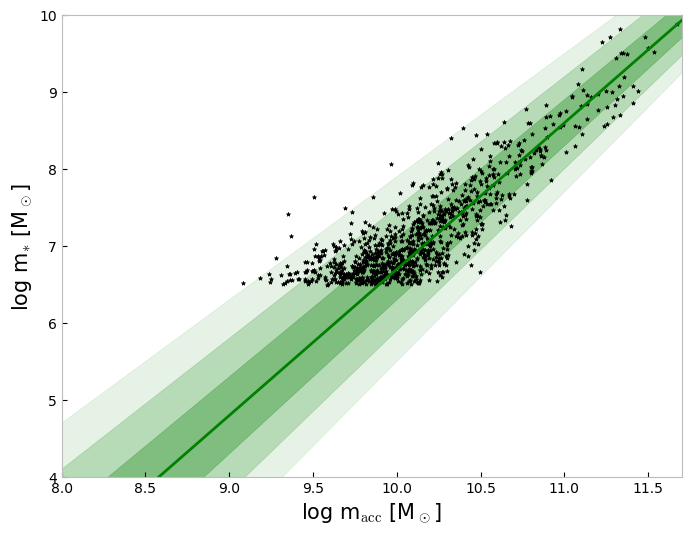

In [149]:
theta = [10.5, 1.9, 0.2, -0.1, 0, 0]

new_SHMR(theta, model_color="green", mock=True, redshift=False)

In [ ]:
theta = [10.5, 2, 0.2, 0, 0, 0]

SHMR_PLOT(theta, mock=True, contour=True, hist2d=True)

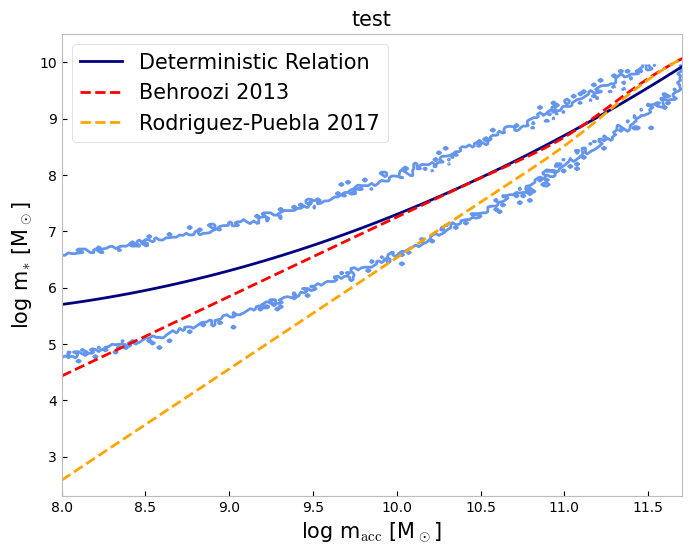

In [55]:
beta = 0.2

theta = [10.5, 2., 0.2, 0.0, beta, 0]

theta_det = [10.5, 2., 0.0, 0.0, beta, 0]

model_label = "test"

shmr_test(theta, theta_det, model_label, legend=True, save_file=None)

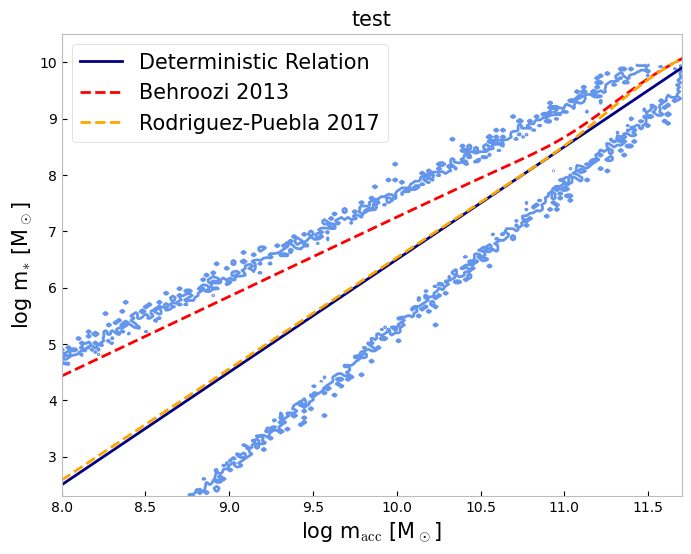

In [51]:
theta = [10.5, 2, 0.2, -0.08, 0, 0]

theta_det = [10.5, 2, 0, 0, 0, 0]

model_label = "test"

shmr_test(theta, theta_det, model_label, legend=True, save_file=None)

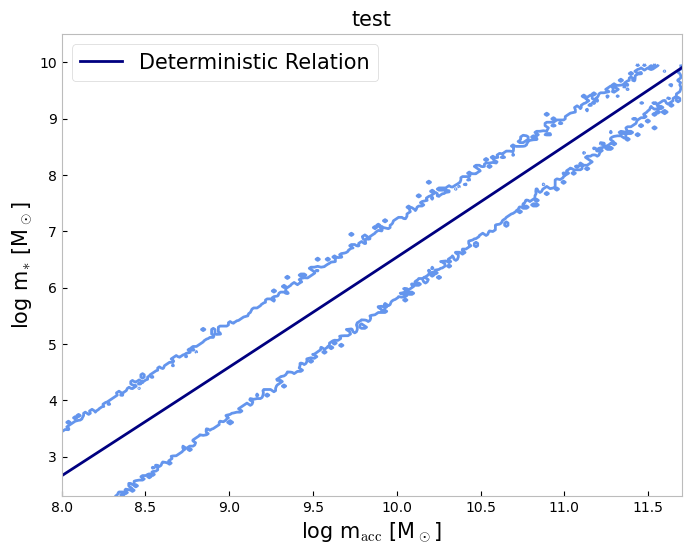

In [43]:
theta = [10.5, 2, 0.2, 0, 0.01, -2]

theta_det = [10.5, 2, 0.0, 0, 0.01, -2]

model_label = "test"

shmr_test(theta, theta_det, model_label, legend=True, save_file=None)

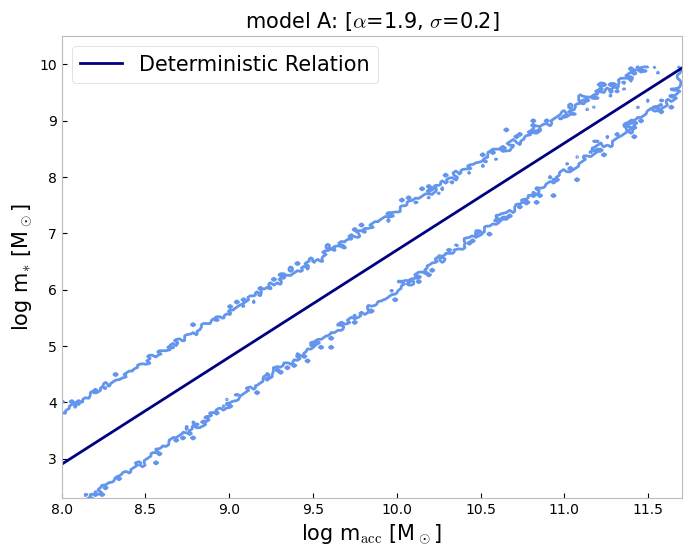

In [9]:
theta = [10.5, 1.9, 0.2, 0, 0, 0]

theta_det = [10.5, 1.9, 0.0, 0, 0, 0]

model_label = "model A: [$\\alpha$="+str(theta[1])+", $\\sigma$="+str(theta[2])+"]"

shmr_test(theta, theta_det, model_label, legend=True, save_file="../../figures/paper/shmr_A.png")

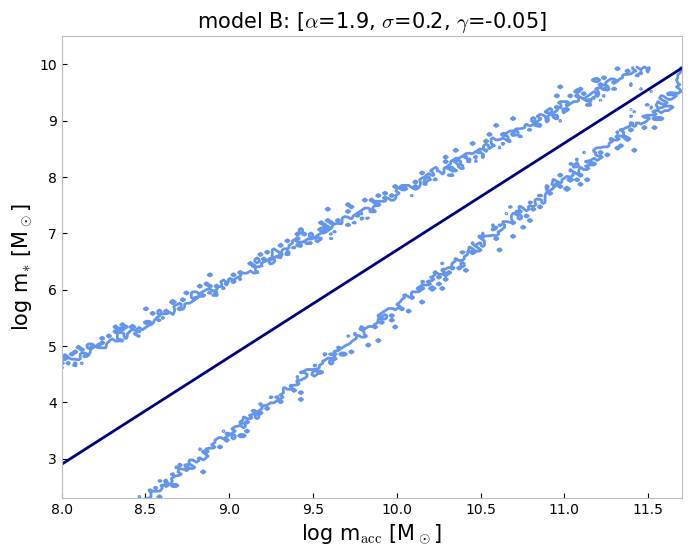

In [10]:
theta = [10.5, 1.9, 0.2, -0.05, 0, 0]

theta_det = [10.5, 1.9, 0.0, 0, 0, 0]

model_label = "model B: [$\\alpha$="+str(theta[1])+", $\\sigma$="+str(theta[2])+", $\\gamma$="+str(theta[3])+"]"

shmr_test(theta, theta_det, model_label, save_file="../../figures/paper/shmr_B.png")

#plot_SHMR_dist(theta, theta_det, model_label)

In [44]:
theta = [10.5, 1.9, 0.2, -0.05, -0.2, 0]

new_theta = theta[:2] + [0, 0] + theta[4:]

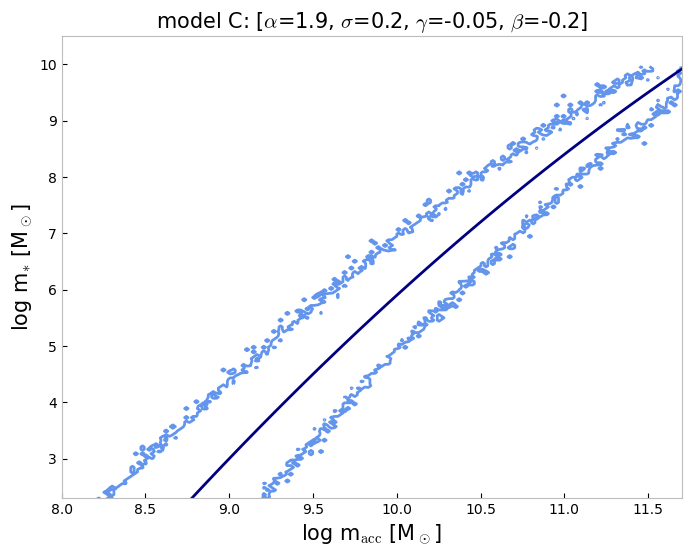

In [11]:
theta = [10.5, 1.9, 0.2, -0.05, -0.2, 0]

theta_det = [10.5, 1.9, 0, 0, -0.2, 0]

model_label = "model C: [$\\alpha$="+str(theta[1])+", $\\sigma$="+str(theta[2])+", $\\gamma$="+str(theta[3])+ ", $\\beta$="+str(theta[4]) + "]"

shmr_test(theta, theta_det, model_label, save_file="../../figures/paper/shmr_C.png")


#plot_SHMR_dist(theta, theta_det, model_label)

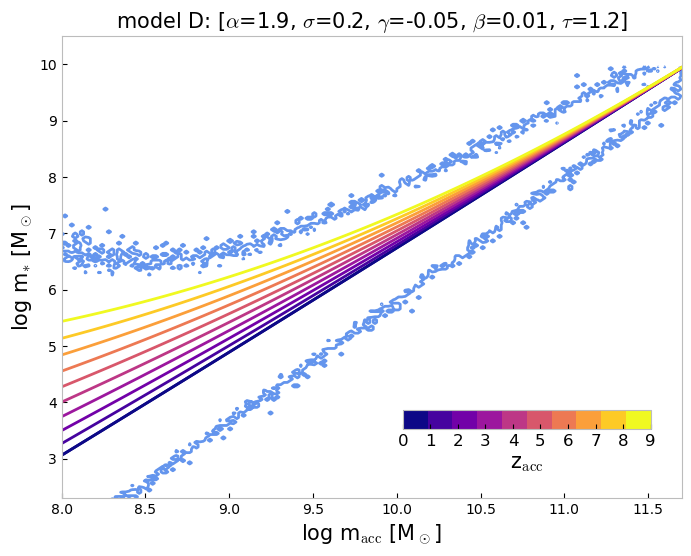

In [12]:
theta = [10.5, 1.9, 0.2, -0.05, 0.01, 1.2]

theta_det = [10.5, 1.9, 0.0, 0, 0.01, 1.2]

model_label = "model D: [$\\alpha$="+str(theta[1])+", $\\sigma$="+str(theta[2])+", $\\gamma$="+str(theta[3])+ ", $\\beta$="+str(theta[4]) + ", $\\tau$="+str(theta[5]) + "]"

shmr_test(theta, theta_det, model_label, redshift=True, save_file="../../figures/paper/shmr_D.png")


#plot_SHMR_dist(theta, theta_det, model_label)

In [13]:
def create_2x2_grid(images):
    fig, axs = plt.subplots(2, 2, figsize=(12,12))

    for i in range(2):
        for j in range(2):
            img = mpimg.imread(images[i * 2 + j])
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
    fig.set_in_layout(False)
    plt.tight_layout(rect=[0, 0, 1.2, 0.95])
    plt.savefig("../../../paper_1/figures/SHMR.pdf", bbox_inches="tight")
    plt.show() 


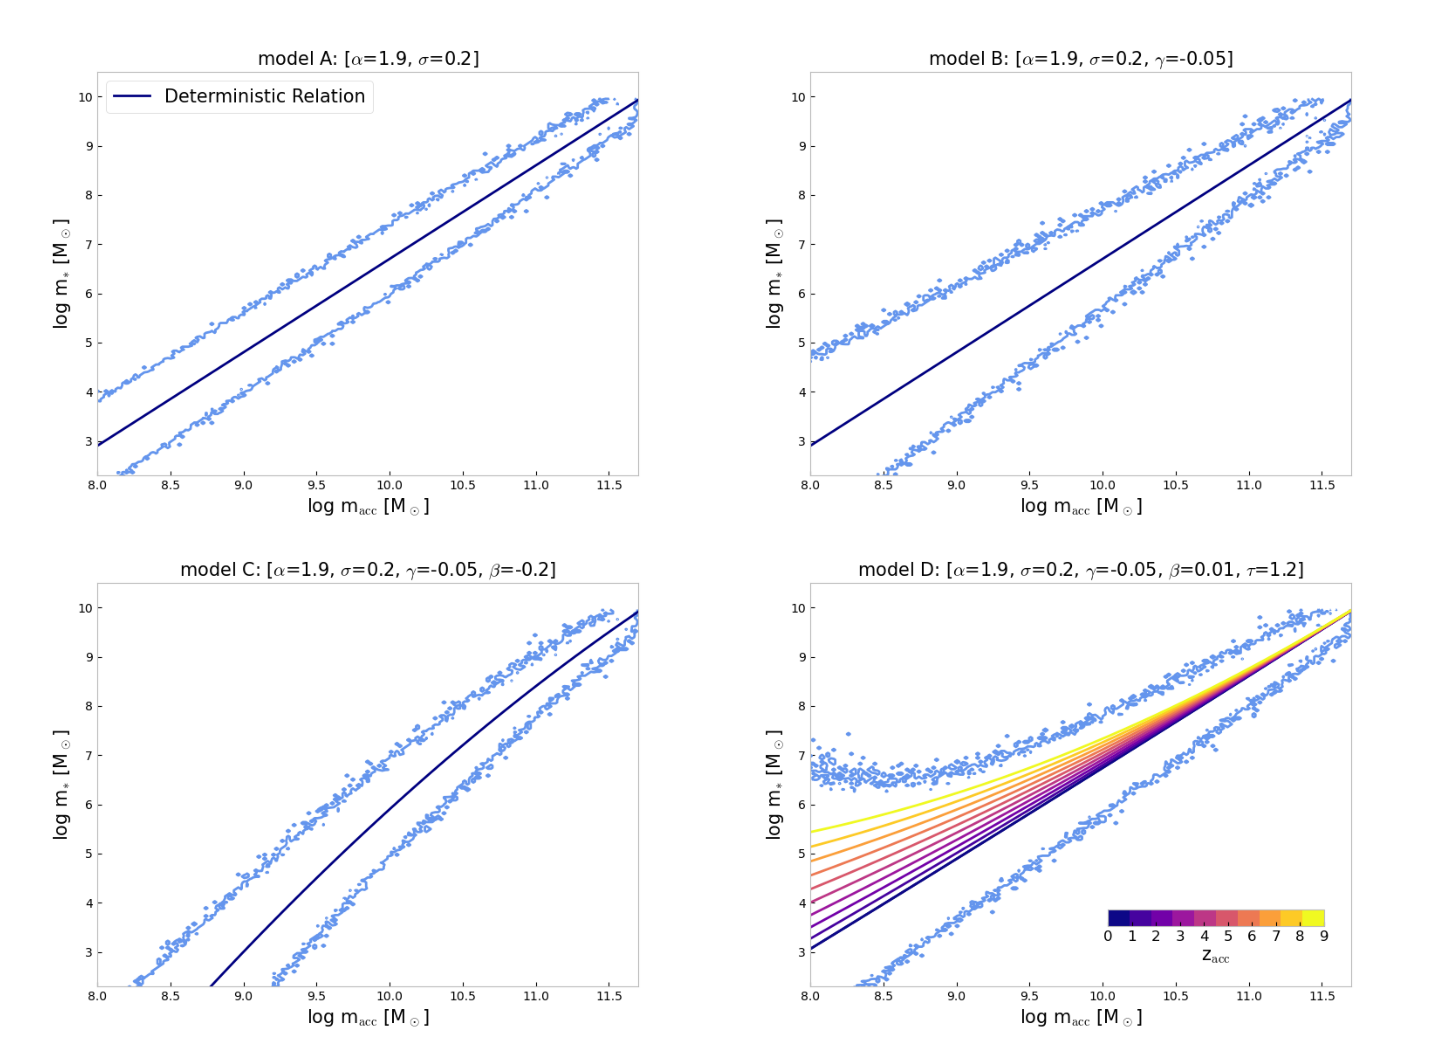

In [14]:

datadir = "../../figures/paper/"

image_paths = [datadir+"shmr_A.png", datadir+"shmr_B.png", datadir+"shmr_C.png", datadir+"shmr_D.png"]

create_2x2_grid(image_paths)
